# Deconvolving spot-based spatial transcriptomics data

## Motivation

Sport-based spatial transcriptomics data extends the classical readout from dissociated single-cell RNA sequencing with spatial locations. While still being squencing based, and therefore being unbiased in the gene space, available methods do not have single-cell resolution. Visium, the commercial version of the original Spatial Transcriptomics protocoll, for example, has circular capture areas with a diameter of 55mu. Dependet on the tissue and spatial location multiple cells map onto a single capture area. In addition, a single cell might only be partly contained within the capture area, leading to further differences from the expression profiles we are used when dealing with classical scRNA-seq data. 

Since the biological entity of interst are single cells, we would like to demix the observed spatial expression profiles back to signals from individual cells. This process is referred to as deconvolution. Deconvolution comes in multiple flavours. The simplest form of deconvolution is to assign propotions of cell types to each spatial location. A more complex approach is to also identify within cell-type variation. Since spatial data by itself does not provide a clear notion of cell type, deconvolution methods usually rely on a single-cell reference. 

While the alignment of reference data with the spatial data can be done in different ways, a very popular approach is to perform a probabilistic mapping where misture parameters are inferred such that compositions of single-cell expression profiles match the spatial expression. 

In this tutorial, we will describe two approaches, Stereoscope and Cell2Location, in more detail and provide a practical tutorial for one of them. We further name a few other methods which are worth testing when encountering the problem of deconvolution.

## A more technical description of deconvolution

In spatial transciptomics, the observed transcriptome can be described as a latent variable model. The observed counts $x_{sg}$ for gene $g$ and spot $s$ is the sum of the cell's contributions $x_{sig}$ that belong to this spot:
$$
    x_{sg} = \sum_{i=1}^{C(s)} x_{sig} \quad .
$$

If one ignores the variability within cell types, the problem of deconvolution simplifies to the identification of counts of cell typea, that is to infer how often a cell type occures $\tilde \beta_{st}$ in each spot:
$$
    x_{sg} = \sum_{i=1}^{C(s)} c_{t(i)g} = \sum_{t=1}^{T} \beta_{st} c_{tg} \quad ,
$$

where $t(i)$ is cell's $i$ cell type and $c_{tg}$ the prototype expression profiles. Note that the sum changes from summing over individual cells $i$ to summing over the disctinct set of cell types $t \in \{1, \dots, C\}$. Here, the parameter $\tilde \beta_{st}$ counts how often a cell type occures in a spot. Through normalisation of the spot's library size $l_s$, this count vector can be changed to indicate cell type proportions:
$$
    x_{sg} = l_s \sum_{t=1}^{T} \beta_{st} c_{tg} \quad .
$$

This problem of identifying cell type proportions $\beta_{st}$ is not easy to solve. One reason for this is limited number of spots within a dataset, usually 3-5k, while measuering almost all protein encoding genes of the human genome, $> 20\text{k}$.

Using reference scRNA-seq measurements, is a good way to alleviate this issue. Their single-cell resolution enables to compute the prototype expression profiles $\boldsymbol{c}_{t}$. Knowing such prototypes reduces the above problem to finding the cell type proportions $\beta_{st}$ within spots. Of course, such a transfer across technologies is only sensible if one can assume that the scRNA-seq profiles are representable for the measured counts in the spatial assay. Ideally, both experiments were conducted on the same tissue slice. 

Over the past two years, multiple methods were introduced that tackle the problem of deconvolution in spatial transcriptomics data. Among others, there are Setreoscope, DestVI, RCTD, SPOTlight, and Cell2Location which we will describe in more detail for exemplary purposes.

## Stereoscope

Stereoscope is a reference deconvolution model, which uses the negative binomial distribution for model both single cell and spatial transcriptomics expression data. It makes the simplifying assumption, that gene expression of cells of one cell type is constant, not just within one spot but globally in the entire dataset:
$$
    c_{tsg} = c_{ts'g} \ \ , \quad  \forall s,s' \in \{1, ..., N_s\} \quad .
$$

Stereoscope uses the above formulation as the rate parameter of a negative binomial distribution and extends it by two additional parameters. First, in order to model the technology dependent capture efficiencies of different genes, they introduce the capture efficiency parameter $e_g$. In addition, they introduce the second parameter of the negative binomial distribution, the success probability $p_g$. This parameter is considered to be shared between genes (this ensures that the $NB$ distribution is closed under summation):
$$
    x_{sg} \sim NB(l_s e_g \sum_{t=1}^{T} \beta_{st} c_{tg}, p_g) \quad .
$$

The expression profiles $c_{tg}$ as well as the success probabilities $p_g$ are obtained from the cell expressions $y_{ig}$ of a reference dataset: 
$$
    y_{ig} \sim NB(d_i c_{tg},p_g) \quad ,
$$

where $d_c = \sum_{g = 1}^G y_{ig}$ is the count depth, i.e. the total number of a cell's transcripts.

As a technical adjustment, a dummy cell type is considered for each spot to model additive shifts between technologies due to differences in the underlying cell types. The final Stereoscope model becomes: 
$$
    x_{sg} \sim NB(l_s e_g \sum_{t=1}^{T} \beta_{st} c_{tg} + \kappa_s \epsilon_g, p_g) \quad ,
$$
where the parameters $\dots$ are learned through $\dots$ optimsation. 

## Cell2location

Another deconvolution model which uses the negative binomial distribution is Cell2Location. In contrast to Stereoscope, it uses the mean parameterisation of the negative binomial. The cell counts for each cell type are modeled directly via the mean $\mu_{sg}$ and the dispersion $a_g$, which is also shared between genes. Additionally, technical parameters $l_s$, $e_g$ and $\epsilon_g$ are used as in Stereoscope to account for multiplicative and additive shift:
$$
    x_{sg} \sim {NB}(\mu_{sg}, a_g) \\ =  {NB}(l_s (e_g \sum_{t=1}^{T} \beta_{st} c_{stg} + \epsilon_g), a_g)
$$

Note that Cell2Location also considers batch and technology effects from using data collected over multiple batches. In order to make the comparison between the models shown easier, this will not be considered here.

In order to regularize parameters, Cell2location makes extensive use of priors which are suposed to match their biological meaning closely. All parameters of the spatial and reference model have priors of some form which are constructed in a hierarchical fashion. This means that the parameters of the prior distributions have themselves priors. Details can be found in the supplementary information of original publication.

A particularly interesting modeling assumption is that the abundance of cell types $\beta_{st}$ itself is modelled as a linear combination of cell type prototypes $\rho_{r}$ (or tissue prototypes). These are modeled to be distributed on the slide with proportion $\pi_s$. This is expressed in a gamma prior with (fixed) prior strength parameter $v$:
$$
    \beta_{st} \sim \text{Gamma}\big((\mu_{sf} v , v)\big) \\
     = \text{Gamma}\Big(\Big(\sum_{r=1}^R \pi_{sf} \rho_{fr} v , v\Big)\Big)
$$
As a reference-based model, Cell2location also relies on scRNA-seq measurements for the cell type profiles $\boldsymbol{c}_t$. The single-cell model is quite similar to the one of Stereoscope but is mean-parametrised and further includes the technical parameter $\hat{\epsilon}_g$:
$$
    y_{cg} \sim {NB}(\mu_{cg}, \hat{a}_g)\\
    =  {NB}(\beta_{tg} + \hat{\epsilon}_g , \hat{a}_g)
$$

The posteriors of the hierarchical models shown here are all intractable. Thus variational inference is used in Cell2Location to infer the full posteriors.

## Cell2Location in practise

Reference: https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html#Visualising-cell-abundance-in-spatial-coordinates

### Importing libraries

In [2]:
import anndata
import cell2location
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sb
import squidpy as sq

Global seed set to 0


### General setup

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.2 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [4]:

data_folder = Path("/nfs/homedirs/hetzell/code/stcti/project_folder/datasets/single_cell")

adata_st = sc.read(data_folder/"37_48_adata_pp_wohires.h5ad")
adata_sc = sc.read(data_folder/"tms_kidney_10x.h5ad")

### Pre-processing of the spatal and single-cell data

In [5]:
adata_sc.var["feature_id"] = adata_sc.var_names
adata_sc.var_names = adata_sc.var["feature_name"].values.tolist()

In [6]:
# Put mitochondrial genes into .obs and remove from count matrix of the spatial data
adata_st.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_st.var.index]
adata_st.obsm['MT'] = adata_st[:, adata_st.var['MT_gene'].values].X.toarray()
adata_st = adata_st[:, ~adata_st.var['MT_gene'].values]

Next, we are checking for the gene overlap between the two datasets

In [7]:
print(f"Genes from TMS in the spatial data: {np.mean([x in adata_st.var_names for x in adata_sc.var_names])}")
print(f"Genes from the spatial data in TMS: {np.mean([x in adata_sc.var_names for x in adata_st.var_names])}")

Genes from TMS in the spatial data: 0.8082290797887128
Genes from the spatial data in TMS: 0.6632899840292037


And we subset both datasets to the same gene set

In [8]:
shared_features = [x for x in adata_st.var_names if x in adata_sc.var_names]
adata_sc = adata_sc[:, shared_features].copy()
adata_st = adata_st[:, shared_features].copy()

In [9]:
# As a result, we now have fewer genes. Let us quickly check the adata objects
adata_st

AnnData object with n_obs × n_vars = 8647 × 14536
    obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'dapi_mean_norm', 'experiment_id', 'organism', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CT010467.1_pct', 'n_genes', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'MT_gene'
    uns: 'experiment_id_colors', 'hvg', 'id_colors', 'leiden', 'leiden_colors', 'matchedVis', 'neighbors', 'organ_colors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'spatial', 'MT'
    varm: 'PCs'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [10]:
adata_sc

AnnData object with n_obs × n_vars = 21639 × 14536
    obs: 'age', 'cell', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'subtissue', 'n_counts', 'louvain', 'leiden', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'cell_type_coarse'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'feature_biotype', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_id'
    uns: 'X_normalization', 'age_colors', 'layer_descriptions', 'leiden', 'louvain', 'neighbors', 'pca', 'publication_doi', 'schema_version', 'title'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Fitting the reference model

In [11]:
from cell2location.utils.filtering import filter_genes


# Use the raw data of the reference model for C2L's gene filtering
adata_sc = anndata.AnnData(
    adata_sc.raw[:, adata_sc.var["feature_id"].values].X,
    var=adata_sc.var,
    obs=adata_sc.obs,
    uns=adata_sc.uns,
)

/nfs/staff-hdd/hetzell/miniconda3/envs/stcti/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


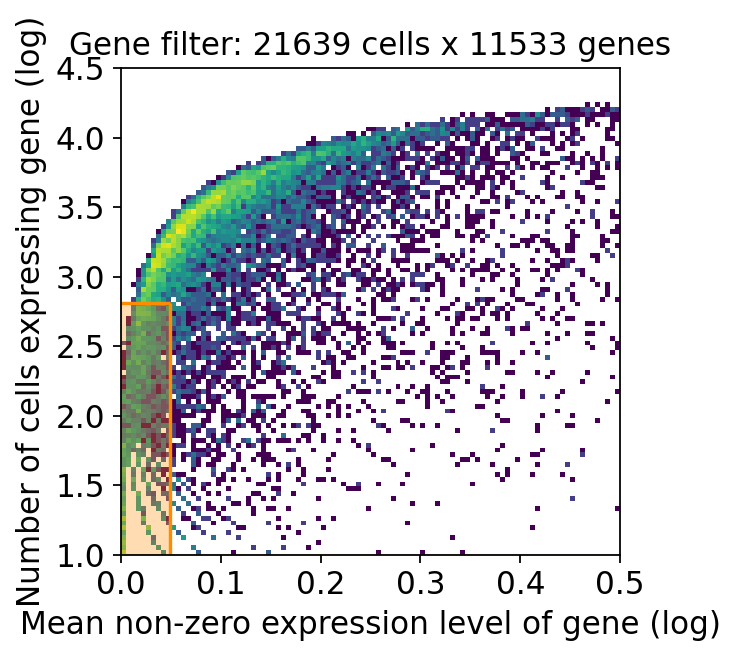

In [12]:
# Reduce both adata to the selected gene set
selected = filter_genes(adata_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_sc = adata_sc[:, selected].copy()
adata_st = adata_st[:, selected].copy()

In [13]:
from cell2location.models import RegressionModel


RegressionModel.setup_anndata(
    adata=adata_sc,
    batch_key='mouse.id',
    labels_key='cell_type',
    categorical_covariate_keys=['method'])

In [14]:
model = RegressionModel(adata_sc)
# default, try on GPU:
use_gpu = True
model.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=use_gpu)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/nfs/staff-hdd/hetzell/miniconda3/envs/stcti/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/nfs/staff-hdd/hetzell/miniconda3/envs/stcti/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:428: UserWarning: The number of training samples (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 250/250: 100%|██████████| 250/250 [10:05<00:00,  2.42s/it, v_num=1, elbo_train=1.31e+8]


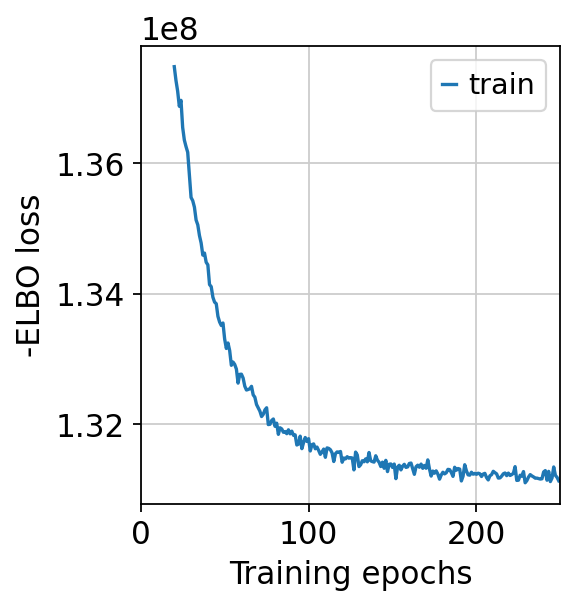

In [15]:
model.plot_history(20)

#### Getting the posterior from C2l

In [16]:
model.export_posterior(
    adata_sc, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': use_gpu}
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:15<00:00, 65.68it/s]


AnnData object with n_obs × n_vars = 21639 × 11533
    obs: 'age', 'cell', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'subtissue', 'n_counts', 'louvain', 'leiden', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'cell_type_coarse', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'feature_biotype', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_id', 'nonz_mean'
    uns: 'X_normalization', 'age_colors', 'layer_descriptions', 'leiden', 'louvain', 'neighbors', 'pca', 'publication_doi', 'schema_version', 'title', '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: '_scvi_extra_categorical_co

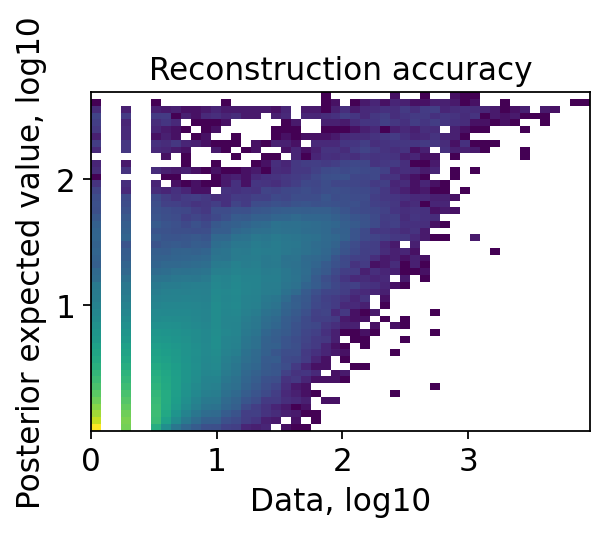

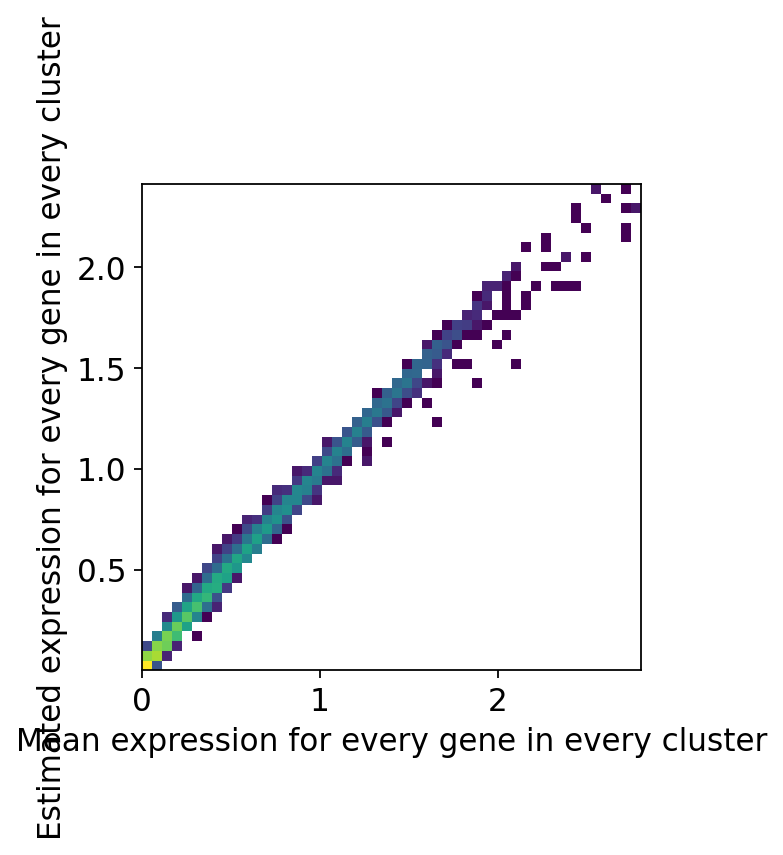

In [17]:
model.plot_QC()

In [18]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_sc.varm.keys():
    inf_aver = adata_sc.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                                              for i in adata_sc.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_sc.var[[f'means_per_cluster_mu_fg_{i}'
                                  for i in adata_sc.uns['mod']['factor_names']]].copy()

In [19]:
inf_aver.columns = adata_sc.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

B cell    T cell  brush cell  \
0610005C13Rik  0.000811  0.003790    2.410163   
0610009B22Rik  0.065874  0.048483    0.861797   
0610009L18Rik  0.041406  0.041716    0.182124   
0610010F05Rik  0.008509  0.012703    0.098685   
0610010K14Rik  0.415812  0.472108    0.611183   

               epithelial cell of proximal tubule  fenestrated cell  
0610005C13Rik                            2.114836          0.054075  
0610009B22Rik                            0.778520          0.211579  
0610009L18Rik                            0.171441          0.025544  
0610010F05Rik                            0.048590          0.071499  
0610010K14Rik                            0.554022          0.799051

### Run Cell2Location

In [20]:
cell2location.models.Cell2location.setup_anndata(
    adata=adata_st,
    batch_key='id',
    layer="counts")

In [21]:
model = cell2location.models.Cell2location(
    adata_st, 
    cell_state_df=inf_aver,
    N_cells_per_location=19,
    detection_alpha=200,
    )

In [22]:
model.train(max_epochs=3000,  # default 3000
          batch_size=None,
          train_size=1,
          use_gpu=use_gpu)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/nfs/staff-hdd/hetzell/miniconda3/envs/stcti/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/nfs/staff-hdd/hetzell/miniconda3/envs/stcti/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:428: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 3000/3000: 100%|██████████| 3000/3000 [11:30<00:00,  4.34it/s, v_num=1, elbo_train=8.13e+7]


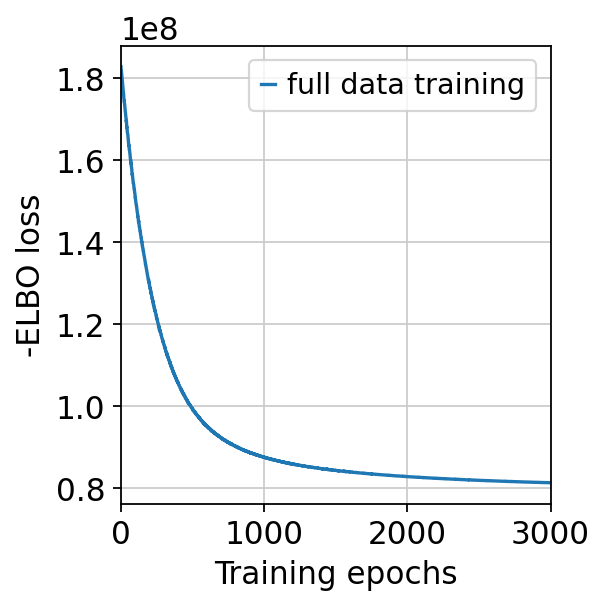

In [24]:
model.plot_history()
plt.legend(labels=['full data training'])

In [25]:
adata_st = model.export_posterior(
    adata_st, sample_kwargs={'num_samples': 1000, 'batch_size': model.adata.n_obs, 'use_gpu': use_gpu}
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:38<00:00, 26.25it/s]


In [26]:
adata_st.obs[adata_st.uns['mod']['factor_names']] = adata_st.obsm['q05_cell_abundance_w_sf']


### Plotting the results

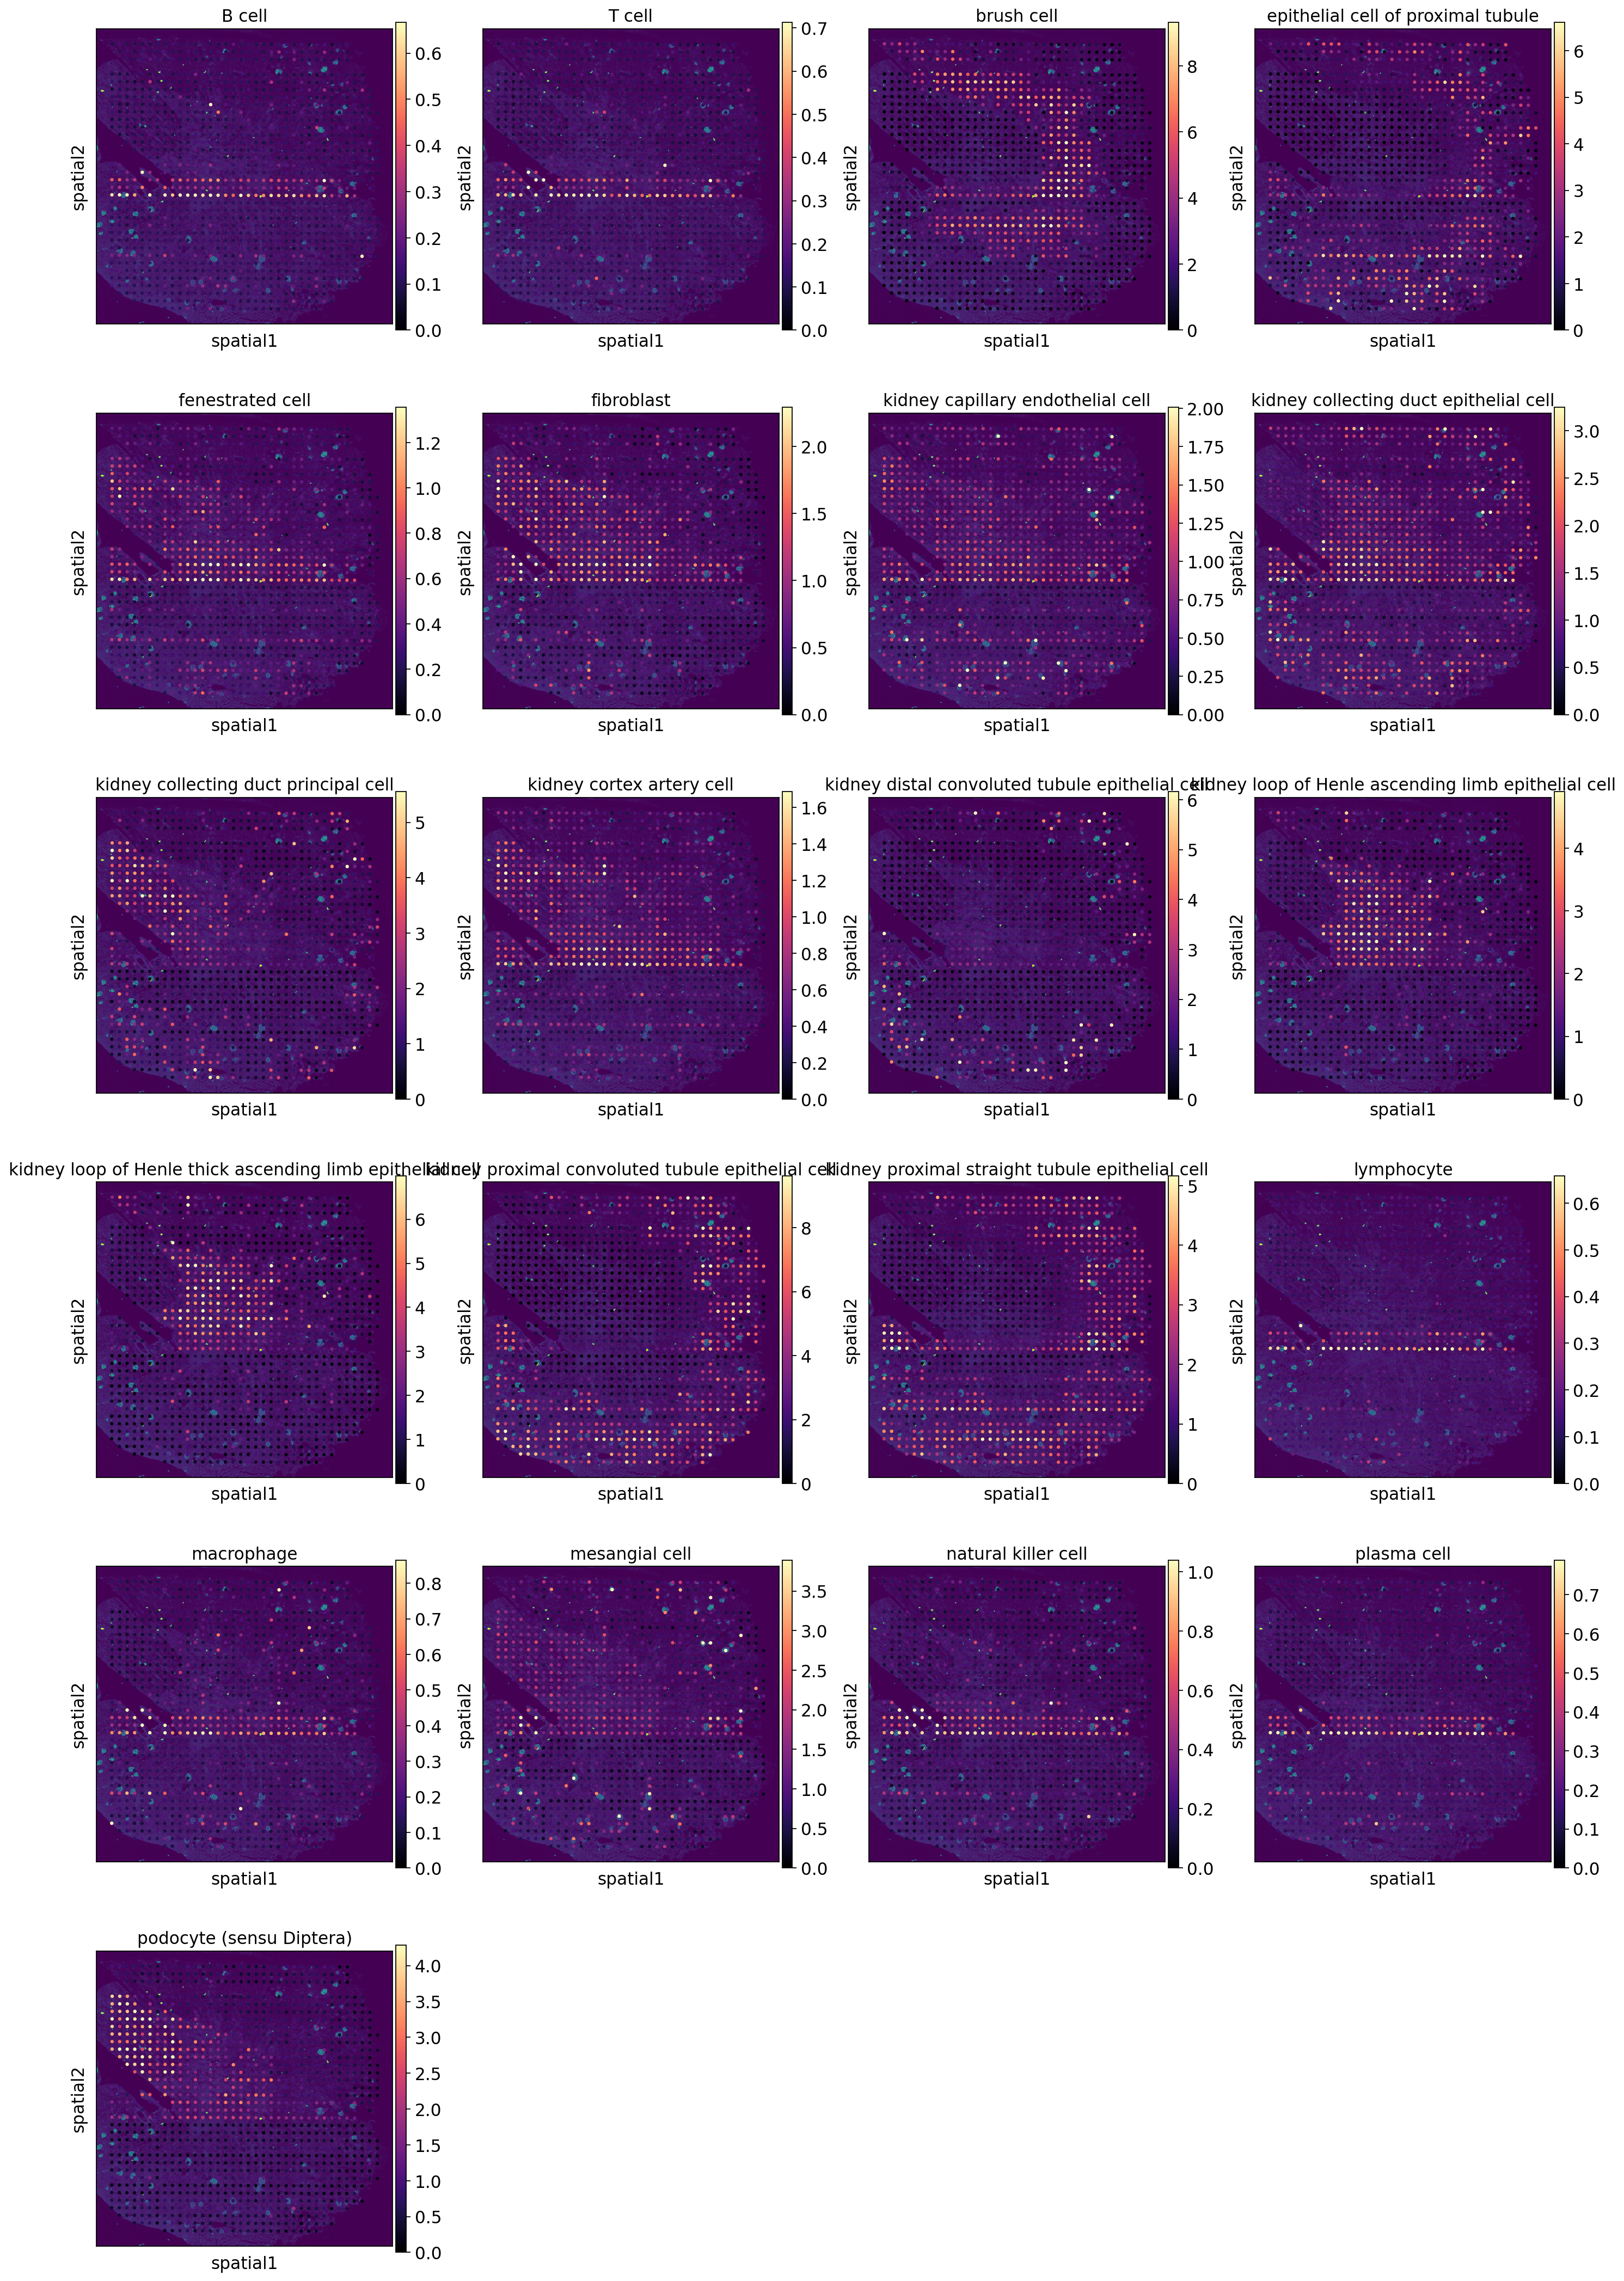

In [27]:
from cell2location.utils import select_slide


slide = select_slide(adata_st, s='37_48_A1', batch_key="id")
with matplotlib.rc_context({'axes.facecolor':  'black', 'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(slide, cmap='magma',
                  color=adata_st.uns['mod']['factor_names'],
                  ncols=4, size=3.,
                  img_key='lowres',
                  vmin=0, vmax='p99.2')

In [23]:
# TODO: Check C2L tutorial for further exlpanation and validation

## Further Models in Reference Based Deconvolution

DestVI incorporates complex nonlinear relationships into the latent variable setup through the use of neural networks. It is the first model that allows for variation of cell type expression prototypes in the data set through a latent variable. These concepts combine to parameterize the mean of a standard negative binomial distribution with gene dependent success probability $p_g$ as in Stereoscope.

RCTD is a reference based deconvolution model which uses the Poisson distribution instead of the more common negative binomial. For its reference cell type prototypes, it simply uses mean expressions for each cell type. This straightforward approach aims for maximum robustness and has shown particular promise in the deconvolution of cell doublets.

SPOTlight uses non-negative matrix factorisation to first decompose the cells by genes matrix from a reference into two parts. First, a cells by topics matrix $H$ and a topics by genes matrix $W$. The matrix $W$ is then transferred to ST where a spots by topics matrix $H'$ is inferred. Topics are not exactly cell types and much care has to be put to ensure that correct latent features are modeled. 